In [1]:

#ini_date = '04/01/23 12:00:00'
#end_date = '06/01/23 13:00:00'
#target_folder="./time-data/evaluation/"

#[9:50, 11/10/2023] Aurora: setup: 20/12/2022 a las 15:00 a. m. hasta el 23/12/2022 a las 15:00 a. m.
#[9:50, 11/10/2023] Aurora: config: 04/01/2023 a las 12:00 a. m. hasta el 06/01/2023 a las 12:00 a. m.

ini_date = '20/12/22 15:00:00'
end_date = '23/12/22 15:00:00'
target_folder="./time-data/setup/"


time_step=15

sensors=["cubiertos", "fridge", "microwave", "ollas"]
interval_activation=[True,True,True,False]
last_next_activation=[False,False,False,False]
tags=["1","2"]

colors={}
colors["1"]="red"
colors["2"]="blue"
colors["3"]="orange"
colors["4"]="green"
colors["5"]="pink"
colors["6"]="brown"



In [2]:
def repaintXY(x,y):
    return int(x*0.08965-196.41+150), int(-y*0.1078+1077)

def repaintXXYY(x,y):
    return int((x+196.41-150)/0.08965), int((y-1077)/(-0.1078))


print(repaintXY(2280,5135))
print(repaintXY(2860,6730))
print(repaintXXYY(209,351))

(157, 523)
(209, 351)
(2848, 6734)


In [3]:
import numpy as np
from pandas import read_csv    

import time

from datetime import datetime

def day_time(ti):
    return int((int)(ti/(60*60*24)))

t0 = (int)(datetime.strptime(ini_date, '%d/%m/%y %H:%M:%S').timestamp())
print (ini_date,"Init date is", t0, "day:",day_time(t0))

tN = (int)(datetime.strptime(end_date, '%d/%m/%y %H:%M:%S').timestamp())
print (end_date,"End date is", tN, "day:",day_time(tN))

def relT(ti):
    return (int)((ti-t0)/time_step)

def absT(tt):
    return (int)(tt*time_step+t0)

nT=(int)(round((tN-t0-1)/time_step))
print(nT)

20/12/22 15:00:00 Init date is 1671544800 day: 19346
23/12/22 15:00:00 End date is 1671804000 day: 19349
17280


In [4]:
S=np.zeros((len(sensors), nT))
for i,sensor in enumerate(sensors):
    series=read_csv(target_folder+sensor+".tsv", sep="\t",parse_dates=True,header=None)
    S[i]=  np.array(series.values[:,[1]]).flatten()  
    print(S[i].shape)
print(S.shape)

(17280,)
(17280,)
(17280,)
(17280,)
(4, 17280)


In [5]:
def intervals(s):
    ret=[]
    lastV=0
    lastI=-1
    for t in range(0,len(s)):
        if(lastV==1 and s[t]==0):
            ret.append((lastI,t-1))
        if(lastV==0 and s[t]==1):
            lastI=t
        lastV=s[t]
    return ret

           

In [6]:
ftw_f1=[1,1,1,1,0.8,0.6,0.4,0.2]
def FTW_f(s,ftw_f):
    s2=np.zeros(len(s))
    for t in range(0,nT):
        s2[t]=0
        for incT in range(0, len(ftw_f)):
            if(t+incT>=(len(s))):
                continue
            s2[t]=max(s2[t],s[t+incT] * ftw_f[incT])
    return s2
def FTW_p(s,ftw_f):
    s2=np.zeros(len(s))
    for t in range(0,nT):
        s2[t]=0
        for incT in range(0, len(ftw_f)):
            if(t-incT<0):
                continue
            s2[t]=max(s2[t],s[t-incT] * ftw_f[incT])
    return s2

def FTW_sensor(s,ftw_f):
    sp=FTW_p(s,ftw_f)
    sf=FTW_f(s,ftw_f)
    s2=np.zeros(len(s))
    for t in range(0,nT):
        s2[t]=min(sp[t],sf[t])
    return s2

ix=range(5110,5130)
s1=S[0]
print(s1[ix])
s2=FTW_f(s1,ftw_f1)
print(s2[ix])
s2=FTW_p(s1,ftw_f1)
print(s2[ix])

s2=FTW_sensor(s1,ftw_f1)
print(s2[ix])

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.  1.  1.  1.  1.  1.  1.  1.  0.8 0.6 0.4 0.2 0.  0.  0.  0.  0.  0.
 0.  0. ]
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


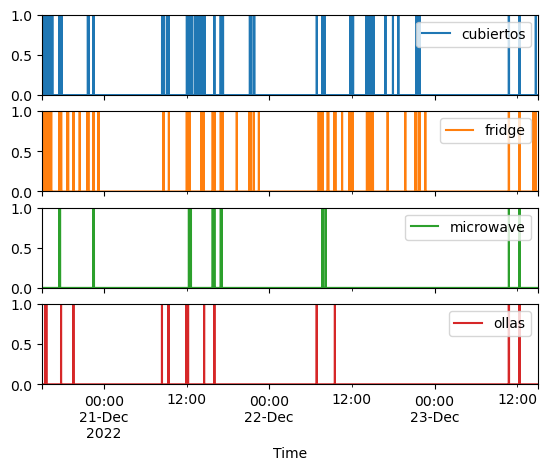

In [7]:
import pandas as pd


def printSensorMatrix(Ss):
    df = pd.DataFrame()
    ts=[]
    for t in range(t0,tN,time_step):
        ts.append(datetime.fromtimestamp( t))

    df['Time']=ts
    for ix,sensor in enumerate(sensors):
        df[sensor]=Ss[ix]
    df.plot(x="Time",y=sensors,subplots=True, legend=True, ylim=(0,1))    
    
printSensorMatrix(S)    

In [8]:
for i,sensor in enumerate(sensors):
    print(i,sensor)
    print("number of time intervals", len(intervals(S[i])))
    #S[i]=FTW_sensor(S[i],ftw_f1)
    print("number of fuzzy time intervals", len(intervals(S[i])))
     

0 cubiertos
number of time intervals 110
number of fuzzy time intervals 110
1 fridge
number of time intervals 116
number of fuzzy time intervals 116
2 microwave
number of time intervals 25
number of fuzzy time intervals 25
3 ollas
number of time intervals 20
number of fuzzy time intervals 20


In [9]:
f = open(target_folder+"S.matrix.tsv", "w")
f.write("TIME")
for i,sensor in enumerate(sensors):
    f.write("\t"+sensor)
f.write("\n")
for t in range(0,nT):
    tt=absT(t)
    f.write(datetime.fromtimestamp(tt).strftime("%Y-%m-%d %H:%M:%S"))
    for i,sensor in enumerate(sensors):
        f.write("\t"+str(S[i][t]))
    f.write("\n")
f.close()

In [10]:
user_location={}
for tag in tags:
    user_location[tag]=[]
    series=read_csv(target_folder+tag+".tsv", sep="\t",parse_dates=True,header=None)
    user_location[tag]=  np.array(series.values[:,[1,2,3,4,5]])  
    print(user_location[tag].shape)
    
print(user_location["1"])

(17280, 5)
(17280, 5)
[['None' 'None' 'None' 'None' 'None']
 ['None' 'None' 'None' 'None' 'None']
 ['None' 'None' 'None' 'None' 'None']
 ...
 ['2028.6040028752798' '6596.97275770177' '2408.723468772463'
  '6786.831092901128' '1']
 ['1870.0145094890609' '6660.8905185847725' '2615.857214599785'
  '6716.993189425442' '1']
 ['1680.1328691776916' '6660.096055971507' '2598.991731657514'
  '6828.048027985753' '1']]


In [11]:
series=read_csv("./sensors-location.tsv", sep="\t",header=None)
print(series.values)
sensor_location={}
for d in series.values:
    for s in d[0].split(","):
        sensor_location[s]=[]
for d in series.values:
    for s in d[0].split(","):
        sensor_location[s].append([float(d[1]),float(d[2]),float(d[3]),float(d[4]),float(d[5])])
    
print(sensor_location)

[['cubiertos' 5200 6000 6200 6940 1.0]
 ['fridge' 2600 6700 3960 6000 1.0]
 ['fridge' 1965 6820 4000 5500 0.5]
 ['microwave' 5730 6600 7120 5830 1.0]
 ['microwave' 5780 7060 6920 5650 0.5]
 ['ollas' 6180 8180 6840 7300 1.0]
 ['ollas' 5770 8370 7220 6620 0.5]
 ['rule-cooking' 4840 8710 6300 7350 0.75]
 ['rule-cooking' 5200 8540 6500 7560 1.0]
 ['rule-lunch' 2100 8000 5000 6580 0.75]
 ['rule-lunch' 2570 7690 4780 6800 1.0]]
{'cubiertos': [[5200.0, 6000.0, 6200.0, 6940.0, 1.0]], 'fridge': [[2600.0, 6700.0, 3960.0, 6000.0, 1.0], [1965.0, 6820.0, 4000.0, 5500.0, 0.5]], 'microwave': [[5730.0, 6600.0, 7120.0, 5830.0, 1.0], [5780.0, 7060.0, 6920.0, 5650.0, 0.5]], 'ollas': [[6180.0, 8180.0, 6840.0, 7300.0, 1.0], [5770.0, 8370.0, 7220.0, 6620.0, 0.5]], 'rule-cooking': [[4840.0, 8710.0, 6300.0, 7350.0, 0.75], [5200.0, 8540.0, 6500.0, 7560.0, 1.0]], 'rule-lunch': [[2100.0, 8000.0, 5000.0, 6580.0, 0.75], [2570.0, 7690.0, 4780.0, 6800.0, 1.0]]}


In [12]:
 def get_iou(bb1, bb2):
    assert bb1[0] <= bb1[2]
    assert bb1[1] <= bb1[3]
    assert bb2[0] <= bb2[2]
    assert bb2[1] <= bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    print(" iou:",[x_left,y_top,x_right,y_bottom])
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    
    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    #iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    print(" intersection_area/bb1_area:",intersection_area,bb1_area)
    if intersection_area==0 or bb1_area==0:
        return 1
    if(intersection_area==bb1_area):
        return 1
    iou = intersection_area / (float(bb2_area))
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
get_iou([22, 25, 22, 26],[10, 20, 30, 50] )

 iou: [22, 25, 22, 26]
 intersection_area/bb1_area: 0 0


1

In [13]:
def getIoSUW(t,sensor, tag):
    iou=0
    if( 'None' in user_location[tag][t]):
        return 0

    x1,y1,x2,y2,w=user_location[tag][t][0],user_location[tag][t][1],user_location[tag][t][2],user_location[tag][t][3],user_location[tag][t][4] 
    #x1,y1=repaintXY(x1,y1)
    #x2,y2=repaintXY(x2,y2) 
    w=1
    for sl in sensor_location[sensor]:
        x1o,y1o,x2o,y2o,wo=sl[0],sl[1],sl[2],sl[3],sl[4]
        #x1o,y1o=repaintXY(x1o,y1o)
        #x2o,y2o=repaintXY(x2o,y2o)
        
        if(x1o>x2o):
            aux=x2o
            x2o=x1o
            x1o=aux
        if(y1o>y2o):
            aux=y2o
            y2o=y1o
            y1o=aux
        if(x1>x2):
            aux=x2
            x2=x1
            x1=aux
        if(y1>y2):
            aux=y2
            y2=y1
            y1=aux

        print("IoU#",[x1,y1,x2,y2],[x1o,y1o,x2o,y2o],)
            
        viou=get_iou([x1,y1,x2,y2],[x1o,y1o,x2o,y2o])
        #print("\t \t", datetime.fromtimestamp(absT(t)).strftime("%Y-%m-%d %H:%M:%S"), " IoU:",tag,viou)
        print("\t \t get_iou_t_s_u",t, tag, viou)
        #iou=max(iou,viou*w*wo)
        iou=iou+viou*w*wo
            
    #print("iou",iou)
    return iou

In [14]:
def Q(x,l,u):
    if(x<=l):
        return 0
    if(x>=u):
        return 1
    return (x-l)/(u-l)
Q(0.8,0.25,0.75)

1

In [15]:
print(sensor_location)
for sensor in sensors:
    for sl in sensor_location[sensor]:
        x1o,y1o,x2o,y2o,wo=sl[0],sl[1],sl[2],sl[3],sl[4]
        sl[0],sl[1]=repaintXY(sl[0],sl[1])
        sl[2],sl[3]=repaintXY(sl[2],sl[3])
        
print(sensor_location)


{'cubiertos': [[5200.0, 6000.0, 6200.0, 6940.0, 1.0]], 'fridge': [[2600.0, 6700.0, 3960.0, 6000.0, 1.0], [1965.0, 6820.0, 4000.0, 5500.0, 0.5]], 'microwave': [[5730.0, 6600.0, 7120.0, 5830.0, 1.0], [5780.0, 7060.0, 6920.0, 5650.0, 0.5]], 'ollas': [[6180.0, 8180.0, 6840.0, 7300.0, 1.0], [5770.0, 8370.0, 7220.0, 6620.0, 0.5]], 'rule-cooking': [[4840.0, 8710.0, 6300.0, 7350.0, 0.75], [5200.0, 8540.0, 6500.0, 7560.0, 1.0]], 'rule-lunch': [[2100.0, 8000.0, 5000.0, 6580.0, 0.75], [2570.0, 7690.0, 4780.0, 6800.0, 1.0]]}
{'cubiertos': [[419, 430, 509, 328, 1.0]], 'fridge': [[186, 354, 308, 430, 1.0], [129, 341, 312, 484, 0.5]], 'microwave': [[467, 365, 591, 448, 1.0], [471, 315, 573, 467, 0.5]], 'ollas': [[507, 195, 566, 290, 1.0], [470, 174, 600, 363, 0.5]], 'rule-cooking': [[4840.0, 8710.0, 6300.0, 7350.0, 0.75], [5200.0, 8540.0, 6500.0, 7560.0, 1.0]], 'rule-lunch': [[2100.0, 8000.0, 5000.0, 6580.0, 0.75], [2570.0, 7690.0, 4780.0, 6800.0, 1.0]]}


In [19]:
print(user_location)
for tag in tags:
    for ti in range(t0,tN,time_step):
        t=relT(ti)
        if( 'None' in user_location[tag][t]):
            continue
        user_location[tag][t]=user_location[tag][t].astype(float)
        user_location[tag][t][0],user_location[tag][t][1]=repaintXY(user_location[tag][t][0],user_location[tag][t][1])
        user_location[tag][t][2],user_location[tag][t][3]=repaintXY(user_location[tag][t][2],user_location[tag][t][3])
print(user_location)                

{'1': array([['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ...,
       ['2028.6040028752798', '6596.97275770177', '2408.723468772463',
        '6786.831092901128', '1'],
       ['1870.0145094890609', '6660.8905185847725', '2615.857214599785',
        '6716.993189425442', '1'],
       ['1680.1328691776916', '6660.096055971507', '2598.991731657514',
        '6828.048027985753', '1']], dtype=object), '2': array([['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ...,
       ['1444.6395288952108', '6217.799021337639', '3606.438794347893',
        '6814.137365608867', '1'],
       ['1775.8313272048736', '6279.352526795736', '2249.853915900609',
        '6744.5617149271', '1'],
       ['2003.9166864544522', '6490.880701847281', '2534.335866169873',
        '6879.045614778247', '1']], dtype=object)}

In [20]:
I=np.zeros((len(tags),len(sensors), nT))
for i,sensor in enumerate(sensors):
    print("Evaluating sensor activation of ",sensor)
    for ii in intervals(S[i]):
        print("\t Interval",ii, datetime.fromtimestamp(absT(ii[0])).strftime("%Y-%m-%d %H:%M:%S"), datetime.fromtimestamp(absT(ii[1])).strftime("%Y-%m-%d %H:%M:%S"))
        for u,tag in enumerate(tags):
            wUS=np.zeros(ii[1]-ii[0]+1)
            for t in range(ii[0],ii[1]+1):
                j=t-ii[0]
                #Esto es solo para sensores retrasados (papelera)
                #wUS[j]=getIoSUW(t-1,sensor,tag)*0.5+getIoSUW(t,sensor,tag)+getIoSUW(t+1,sensor,tag)*0.5
                if(last_next_activation[i]):
                    wUS[j]=getIoSUW(t-1,sensor,tag)*0.5+getIoSUW(t,sensor,tag)+getIoSUW(t+1,sensor,tag)*0.5
                else:
                    wUS[j]=getIoSUW(t,sensor,tag)
                if(not interval_activation[i]):
                    I[u][i][t]=wUS[j]
            wSA=S[i][ii[0]:ii[1]+1]
            wUI=np.dot(wSA,wUS)/float(np.sum(wSA))
            #print("\t \t  User ",tag," wUI:",wUI, "Q(wUI):",Q(wUI,0.00001,0.01))
            #I[u][i][range(ii[0],ii[1]+1)]=Q(wUI,0.00001,0.01)
            if(interval_activation[i]):
                I[u][i][range(ii[0],ii[1]+1)]=wUI

    
            

Evaluating sensor activation of  cubiertos
	 Interval (48, 49) 2022-12-20 15:12:00 2022-12-20 15:12:15
IoU# [326, 483, 401, 573] [419, 328, 509, 430]
 iou: [419, 483, 401, 430]
	 	 get_iou_t_s_u 48 1 0.0
IoU# [321, 472, 399, 590] [419, 328, 509, 430]
 iou: [419, 472, 399, 430]
	 	 get_iou_t_s_u 49 1 0.0
IoU# [317, 329, 474, 436] [419, 328, 509, 430]
 iou: [419, 329, 474, 430]
 intersection_area/bb1_area: 5555 16799
	 	 get_iou_t_s_u 48 2 0.605119825708061
IoU# [167, 373, 491, 496] [419, 328, 509, 430]
 iou: [419, 373, 491, 430]
 intersection_area/bb1_area: 4104 39852
	 	 get_iou_t_s_u 49 2 0.4470588235294118
	 Interval (124, 124) 2022-12-20 15:31:00 2022-12-20 15:31:00
IoU# [478, 308, 630, 427] [419, 328, 509, 430]
 iou: [478, 328, 509, 427]
 intersection_area/bb1_area: 3069 18088
	 	 get_iou_t_s_u 124 1 0.33431372549019606
IoU# [525, 276, 705, 420] [419, 328, 509, 430]
 iou: [525, 328, 509, 420]
	 	 get_iou_t_s_u 124 2 0.0
	 Interval (128, 129) 2022-12-20 15:32:00 2022-12-20 15:32:15


In [21]:
for u,tag in enumerate(tags):
    f = open(target_folder+tag+".matrix.tsv", "w")
    f.write("TIME")
    for i,sensor in enumerate(sensors):
        f.write("\t"+sensor)
    f.write("\n")
    for t in range(0,nT):
        tt=absT(t)
        f.write(datetime.fromtimestamp(tt).strftime("%Y-%m-%d %H:%M:%S"))
        for i,sensor in enumerate(sensors):
            f.write("\t"+str(I[u][i][t]))
        f.write("\n")
    f.close()

In [22]:
tt_date = ini_date
tt = (int)(datetime.strptime(tt_date, '%d/%m/%y %H:%M:%S').timestamp())
print (tt_date,"TT date is", tt_date, "day:",day_time(tt))

for i,sensor in enumerate(sensors):
    f = open(target_folder+sensor+".matrix.tsv", "w")
    f.write("TIME")
    for u,tag in enumerate(tags):
        f.write("\t"+tag)
    f.write("\n")
    for t in range(0,nT):
        tt0=absT(t)
        if(tt0<tt):
            continue
        f.write(datetime.fromtimestamp(tt0).strftime("%Y-%m-%d %H:%M:%S"))
        for u,tag in enumerate(tags):
            f.write("\t"+str(I[u][i][t]).replace('.',','))
        f.write("\n")
    f.close()

20/12/22 15:00:00 TT date is 20/12/22 15:00:00 day: 19346


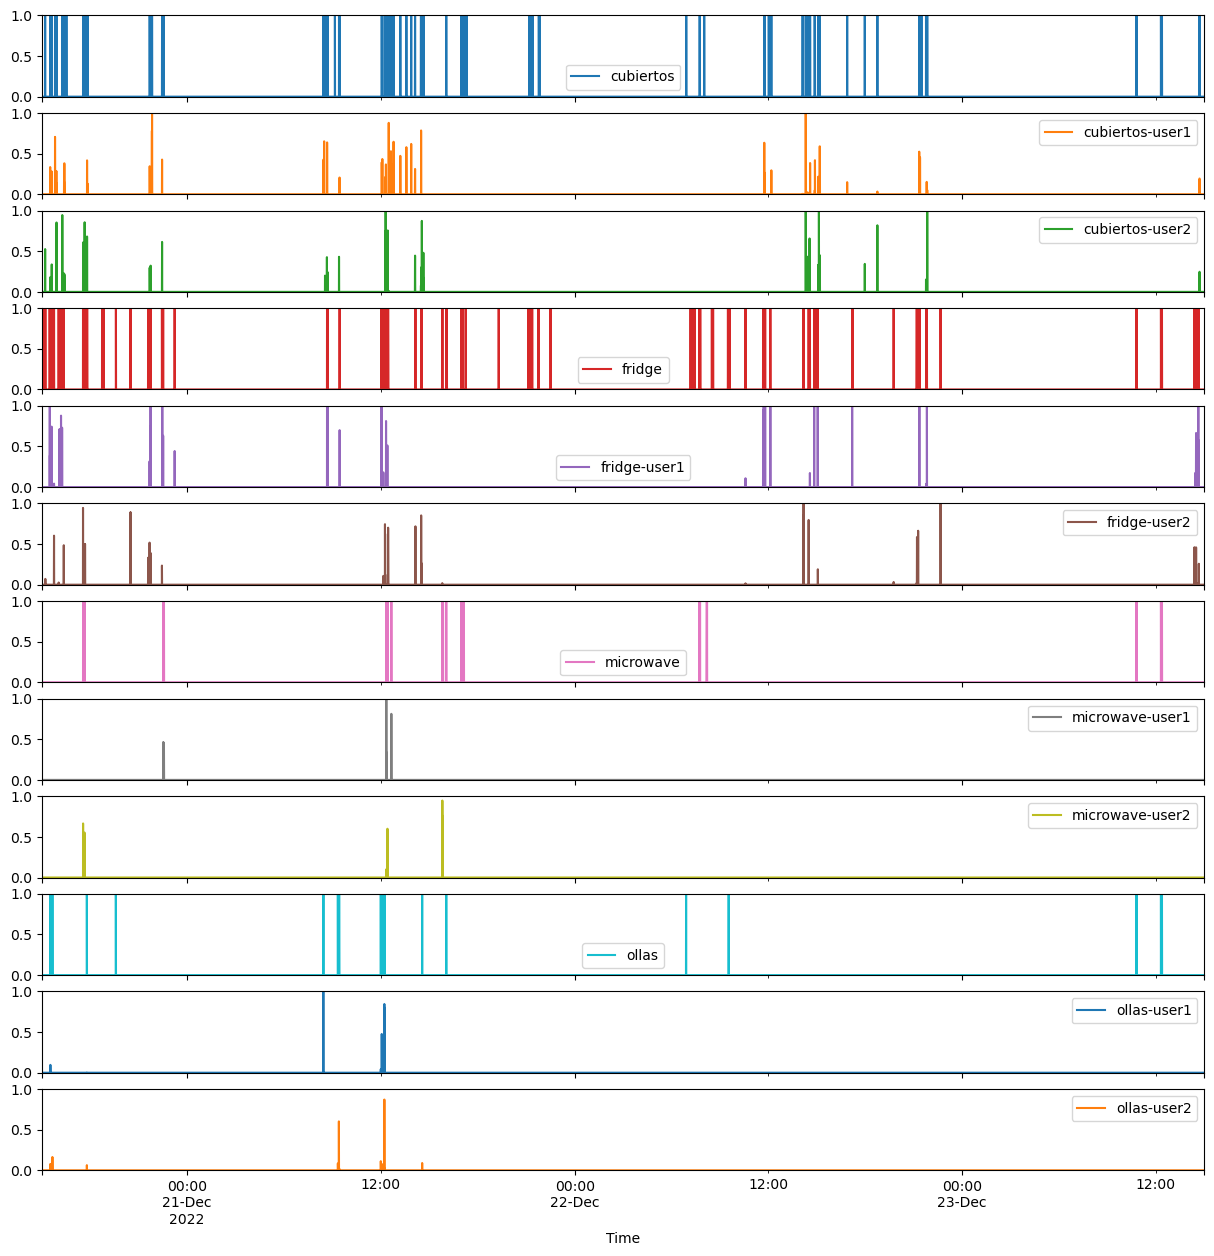

In [23]:
def prinUserSensorMatrix(I,S):
    df = pd.DataFrame()
    ts=[]
    for t in range(t0,tN,time_step):
        ts.append(datetime.fromtimestamp( t))

    df['Time']=ts
    ls=[]
    for ix,sensor in enumerate(sensors):
        df[sensor]=S[ix]
        ls.append(sensor)
        for ux,tag in enumerate(tags):
            df[sensor+"-user"+tag]=I[ux][ix]
            ls.append(sensor+"-user"+tag)
    df.plot(x="Time",y=ls,subplots=True, legend=True, ylim=(0,1), figsize=(15,15))    
    
prinUserSensorMatrix(I,S)